In [2]:
CLUSTER_TYPE ='docker_cluster'
%env CLUSTER_TYPE $CLUSTER_TYPE
from dask.distributed import Client
client = Client('dask-scheduler:8786')
client

env: CLUSTER_TYPE=docker_cluster


<Client: 'tcp://172.25.0.2:8786' processes=4 threads=4, memory=3.81 GiB>

In [4]:
from time import time

from multiprocessing import cpu_count

import numpy as np
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt

import dask
import dask.array as da
import dask.dataframe as dd
from dask import compute
from dask import delayed
from dask.distributed import wait

import dask_ml.datasets
import dask_ml.cluster

import sklearn.cluster
##from sklearn.model_selection import train_test_split
#from sklearn.metrics import accuracy_score

# Utils

In [5]:
#we want to work with dask array, hence we trasform everything to dask arrays
def make_da(X):
        if isinstance(X, dd.DataFrame):
            X = X.to_dask_array(lengths=True)
            
        if isinstance(X, da.core.Array): 
            return X
        
        else: raise ValueError("input is neither a dask array nor a dask dataframe")
        return X

def get_random(p):
    x = np.random.random()
    return x < p

In [6]:
def evaluate_cost(X, centroids): # (da.Array, np.array) -> float
    distances_matrix = dask_ml.metrics.pairwise_distances(X, centroids) 
    tot = da.power(distances_matrix.min(axis=1), 2).sum()
    return tot

def get_min_distances(X, centroids):
    distances_matrix = dask_ml.metrics.pairwise_distances(X, centroids)
    closest_centroid= da.argmin(distances_matrix, axis=1)
    #min_distances= distances_matrix[da.arange(len(distances_matrix)), closest].T #fancy indexing not supported yet
    min_distances= da.min(distances_matrix, axis=1) #fix this!!!!
    return da.power(min_distances, 2), closest_centroid

def update(distances, l):
    p = l * distances/distances.sum()
    mask = da.map_blocks(get_random ,p)
    return X[mask,:]

### K-means ++

In [7]:
def k_means_pp(centroids, counts, k): #explore alternatives
    probs= counts/counts.sum()
    tot_init= len(centroids)
    centroid_index=np.arange(len(centroids))
    final_index= np.random.choice(centroid_index, size=k, replace=False, p=probs)
    return centroids[final_index]

# Scalable K-means: K-means||

### Obeservations:
- The centroids should be a numpy array stored in the machine. This way we can calculate distances without having to move data accross the nodes. This would have happened if the centroids array was distributed throughout the nodes.
- It should be optimized the way we compute the distances, as for now we are computing them multiple times but it would be smarter to keep track only of the min distance and the index of the closest centroid.
- This operation is just to shuffle the centroids in the order number of close data samples:  `centroids[centroid_index]`

 

In [8]:
def k_means_scalable(X, k, l): 
    X=make_da(X)
    n = X.shape[0]
    idx = np.random.randint(0, n)
    centroids = da.compute(X[idx, np.newaxis])[0] #since we computed it, it is a numpy array stored here, not on nodes.
    inital_cost = evaluate_cost(X ,centroids).compute()
    iterations = int(np.round(np.log(inital_cost)))
    for i in range(np.max([iterations, int(k/l)])):
        distances, closest_centroid = get_min_distances(X, centroids)
        new_centroids = update(distances, l).compute()
        centroids = np.vstack((centroids, new_centroids))
    final_distances, final_closest_centroid = get_min_distances(X, centroids)
    result= da.unique(final_closest_centroid, return_counts=True)
    centroid_index, centroid_counts= compute(result)[0]
    if len(centroids) < k : #this raises an error it need to be written again
        missing_centroids = k - len(centroids)
        random_index = np.random.choice(a = len(X), size=(1, 3))
        additional_centroids = X[random_index].compute()
        centroids = np.vstack((centroids, additional_centroids))#fix this
    centroids_pp = k_means_pp(centroids, centroid_counts, k)
    return centroids_pp #this are the initial centroids for the Lloyd's algorithm.

## Test function

In [9]:
###Check this bc it's hard to understand
'''
def get_chunks(X, mem_usage=0.6):
    num_workers = 0
    memory_worker = np.array([])
    for i in client.scheduler_info()['workers']:
        memory_worker = np.append(memory_worker, client.scheduler_info()['workers'][i]['memory_limit'])
        num_workers += 1
    return np.max((int(X.nbytes/(memory_worker.min()*mem_usage)) + 1, len(X)/num_workers))
    

X, y = dask_ml.datasets.make_blobs(1000,n_features=2 ,centers=7, chunks=8)
X.rechunk(get_chunks(X) ,X.shape[1])
#Check in depth what chunks are
#X.persist()
'''

"\ndef get_chunks(X, mem_usage=0.6):\n    num_workers = 0\n    memory_worker = np.array([])\n    for i in client.scheduler_info()['workers']:\n        memory_worker = np.append(memory_worker, client.scheduler_info()['workers'][i]['memory_limit'])\n        num_workers += 1\n    return np.max((int(X.nbytes/(memory_worker.min()*mem_usage)) + 1, len(X)/num_workers))\n    \n\nX, y = dask_ml.datasets.make_blobs(1000,n_features=2 ,centers=7, chunks=8)\nX.rechunk(get_chunks(X) ,X.shape[1])\n#Check in depth what chunks are\n#X.persist()\n"

In [10]:
num_workers = len(client.ncores())
memory_worker = 0.95e9
mem_usage = 0.6
N=100
X, y = dask_ml.datasets.make_blobs(N, n_features=2 ,centers=4, chunks=N/num_workers)
X.persist()

dask.array<concatenate, shape=(100, 2), dtype=float64, chunksize=(25, 2), chunktype=numpy.ndarray>

In [11]:
test_scalable_centroids= k_means_scalable(X, k=4, l=2)
test_scalable_centroids

array([[ 5.70863531,  8.71116162],
       [-9.50692979, -7.79755699],
       [-7.33951583, -8.69297472],
       [-8.27184962, -7.9965845 ]])

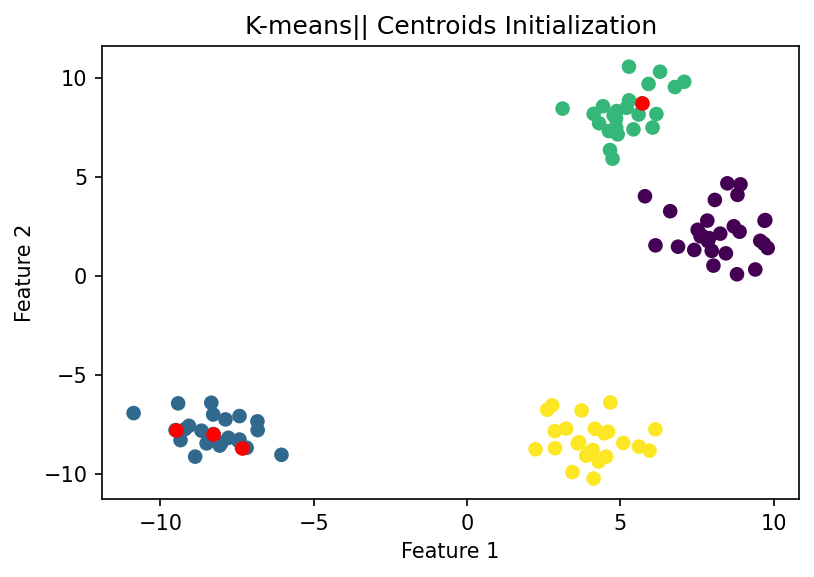

In [12]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(test_scalable_centroids[:,0], test_scalable_centroids[:,1],c='red')
plt.title("K-means|| Centroids Initialization")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

# Scalable Lloyd's Algorithm

### Using Dask Arrays

In [ ]:
def lloyd_scalable (X, k, centroids = None, maxIter = 1000, patience = 1e-6):
    if centroids is None:
        random_index = np.random.choice(len(X), size=(1, k), replace=False)
        centroids = np.array(X[random_index[0]])
    epoch = 1
    while (epoch < maxIter):
        indeces = da.argmin(dask_ml.metrics.pairwise_distances(X, centroids), axis=1)
        new_centroids = da.zeros((k, X.shape[1]))
        for i in range(indeces.max()):
            new_centroids[i] = X[indeces == i].mean()
        epoch = epoch + 1
    return new_centroids.compute()

### Using Dask Dataframes

In [13]:
def lloyd_scalable_df(k, X, centroids = None, maxIter = 50, patience = 1e-7):
    if centroids is None:
        random_index = np.random.choice(len(X), size=(1, k), replace=False)
        centroids = X[random_index[0]]
        
    closest_centroid = get_min_distances(X, centroids)[1]
    df=dd.from_array(da.hstack((X, closest_centroid[:,None])))
    df=df.rename(columns={df.columns[-1]: 'closest_centroid'})
    dc=1
    iteration=0
    while ((dc > patience) & (iteration< maxIter)):
        new_centroids= df.groupby('closest_centroid').mean().compute().to_numpy()
        x=df.drop('closest_centroid', axis=1).to_dask_array()
        df['closest_centroid'] = get_min_distances(x, centroids)[1]
        #dc= np.linalg.norm(new_centroids-centroids) #fix this
        centroids=new_centroids
        iteration +=1
    return centroids


In [14]:
test_lloyd_centroids= lloyd_scalable_df(k=4, X=X, centroids= test_scalable_centroids)

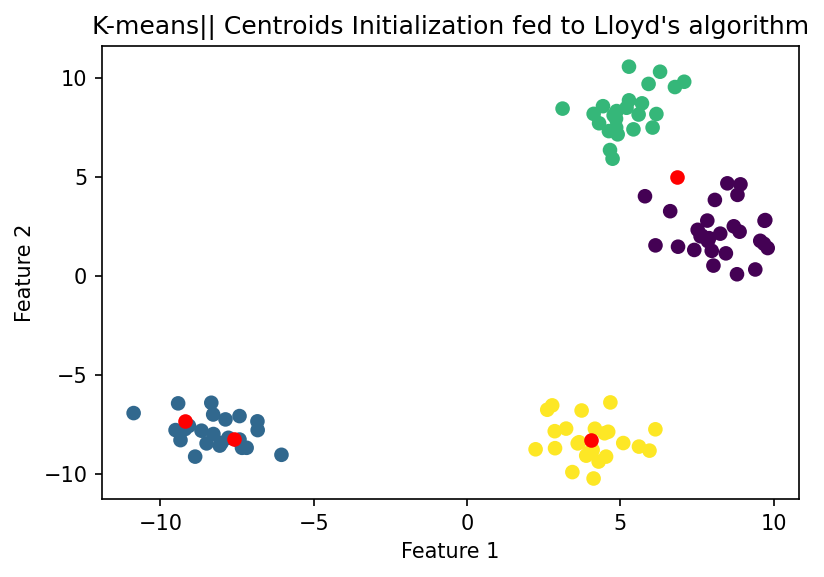

In [15]:
import matplotlib.pyplot as plt
plt.figure(dpi=150)
plt.scatter(X[:,0], X[:,1], c=y)
plt.scatter(test_lloyd_centroids[:,0], test_lloyd_centroids[:,1],c='red')
plt.title("K-means|| Centroids Initialization fed to Lloyd's algorithm")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()

In [34]:
client.restart()

<Client: 'tcp://172.25.0.2:8786' processes=0 threads=0, memory=0 B>